In [1]:
import gym
import numpy as np
import torch,pickle
import time,copy,os
import matplotlib.pyplot as plt
#env_name='Reacher-v2'
env_name='Acrobot-v1'
model_name_suffix=''
#model_name_suffix='_all_success'
env=gym.make(env_name)
model_save_path='./trans_model_data'+model_name_suffix+'/'+env_name+'_model_lr0.0001_nodes512_seed0_epochs_50'
norm_path='./trans_model_data/'+env_name+'_normalization/normalization_arr'
with open(model_save_path, 'rb') as pickle_file:
    model = torch.load(pickle_file, map_location='cpu')
with open(norm_path, 'rb') as pickle_file:
    x_norm_arr, y_norm_arr = pickle.load(pickle_file)
    x_mean_arr, x_std_arr = x_norm_arr[0], x_norm_arr[1]
    y_mean_arr, y_std_arr = y_norm_arr[0], y_norm_arr[1]

def normalize(data,x_std_arr,x_mean_arr):
    return (data - x_mean_arr[:data.shape[-1]]) / x_std_arr[:data.shape[-1]]
def denormalize(data,y_std_arr,y_mean_arr):
    return data * y_std_arr[:data.shape[-1]] + y_mean_arr[:data.shape[-1]]
def mstep_predict_reacher(num_steps,state,ac,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr):
    next_state_arr=np.empty((0,8))
    for i in range(num_steps):
        sa=np.concatenate([state,ac])
        inpt = normalize(sa,x_std_arr,x_mean_arr)
        inpt = torch.tensor(inpt, dtype=torch.float)
        state_delta = model(inpt)    
        state_delta = state_delta.detach().numpy()
        state_delta = denormalize(state_delta,y_std_arr,y_mean_arr)
        next_state= sa[:8] + state_delta
        next_state_arr=np.concatenate((next_state_arr,next_state.reshape(1,8)),axis=0)
        state=next_state
    return next_state, next_state_arr
def mstep_predict_acro(num_steps,state,ac,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr):
    next_state_arr=np.empty((0,6))
    for i in range(num_steps):
        sa=np.concatenate([state,ac])
        inpt = normalize(sa,x_std_arr,x_mean_arr)
        inpt = torch.tensor(inpt, dtype=torch.float)
        state_delta = model(inpt)    
        state_delta = state_delta.detach().numpy()
        state_delta = denormalize(state_delta,y_std_arr,y_mean_arr)
        next_state= sa[:6] + state_delta
        next_state_arr=np.concatenate((next_state_arr,next_state.reshape(1,6)),axis=0)
        state=next_state
    return next_state, next_state_arr
def dist(start_loc,end_loc):
    return np.linalg.norm(end_loc-start_loc)
def dist_acro(state_h):
    sh=-state_h[:,0] -(state_h[:,0]*state_h[:,2]-state_h[:,1]*state_h[:,3])
    return np.sum(np.abs(np.roll(sh,-1)[:-1]-sh[:-1]))
def calc_g(parent,child):
    return parent.g+dist(parent.loc,child.loc)
def calc_g_acro(parent,child):
    return parent.g+dist_acro(child.state_h)
def calc_g_acro(parent,child):
    return parent.g+np.abs(child.loc-parent.loc)
def calc_step(parent,child):
    return parent.step+1
def calc_h(child,goal_loc):
    return dist(child.loc,goal_loc)
def calc_h_acro(child,goal_height):
    return max(0,goal_height-child.loc)

def priority_sort(f_fringe):
    index=np.random.choice(np.argwhere(f_fringe==np.min(f_fringe)).reshape(-1),1)[0]
    #index=list(np.argwhere(f_fringe==np.min(f_fringe)))[-1][0]
    return index

class mnode_reacher(object):
    def __init__(self,state,num_steps,state_h):
        self.num_steps=num_steps
        self.state=state
        self.loc=state[-2:]
        self.vel=state[-4:-2]
        self.state_h=state_h
        self.prev=None
        self.g=0
        self.ng=0
        self.step=0
        self.f=0
        self.action=np.repeat(np.array([0,0]).reshape(1,2),num_steps,axis=0)
    def add_prev(self,prev_node,action):
        self.prev=prev_node
        self.g=calc_g(prev_node,self)
        self.ng=0
        self.step=calc_step(prev_node,self)
        self.action=np.repeat(action.reshape(1,2),self.num_steps,axis=0)
    def calc_f(self,h,action,goal_loc,mode):
        if mode=='shortest_path':
            self.f=self.g+h
        elif mode=='quickest_search':
            self.f=h
            
class mnode_acro(object):
    def __init__(self,state,num_steps,state_h):
        self.num_steps=num_steps
        self.state=state
        self.loc=-state[0]-(state[0]*state[2]-state[1]*state[3])
        self.vel=state[-2:]
        self.state_h=state_h
        self.prev=None
        self.g=0
        self.ng=0
        self.step=0
        self.f=0
        self.action=np.repeat(np.array([0]).reshape(1,1),num_steps,axis=0)
    def add_prev(self,prev_node,action):
        self.prev=prev_node
        self.g=calc_g_acro(prev_node,self)
        self.ng=0
        self.step=calc_step(prev_node,self)
        self.action=np.repeat(action.reshape(1,1),self.num_steps,axis=0)
    def calc_f(self,h,mode):
        if mode=='shortest_path':
            self.f=self.g+h
        elif mode=='quickest_search':
            self.f=h
            
def mstep_isvalid_reacher(child):
    if not mstep_in_hull_reacher(child.state_h[:,-2:]):
        return False
    #QVEL
    #elif not ((child.state_h[:,2:]>=1).all() and (child.state_h[:,2:]<=120).all()): 
    #    return False
    #QPOS opposite direction
    #elif child.state_h[-1,0]*goal_loc[0]<=0:
    #    return False
    else:
        return True

def mstep_isvalid_acro(child):
    if not mstep_in_hull_acro(-child.state_h[:,0]-(child.state_h[:,0]*child.state_h[:,2]-child.state_h[:,1]*child.state_h[:,3])):
        return False
    #QVEL
    #elif not ((child.state_h[:,2:]>=1).all() and (child.state_h[:,2:]<=120).all()): 
    #    return False
    #QPOS opposite direction
    #elif child.state_h[-1,0]*goal_loc[0]<=0:
    #    return False
    else:
        return True
    
def mstep_in_hull_reacher(p):
    if (np.linalg.norm(p,axis=1)>0.22).any():
        #print(np.linalg.norm(p,axis=1))
        return False
    else:
        return True
    
def mstep_in_hull_acro(p):
    if (np.abs(p)>2.2).any():
        #print(np.abs(p))
        return False
    else:
        return True

In [2]:
def Astar_discrete_mstep_reacher(mode,num_steps,initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,big_goal_radius=0.02):
    actions=[np.array([-1,1]),np.array([1,-1]),np.array([1,1]),np.array([-1,-1]),np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0]),np.array([0,0])]
    
    initial=mnode_reacher(initial_state,num_steps,np.repeat(initial_state.reshape(1,8),num_steps,axis=0))
    fringe=[initial]
    #initial.calc_f(dist(initial.loc,goal_loc))
    state_fringe=[initial.state]
    f_fringe=[initial.f]
    state_closed_set=[]
    
    max_size_fringe=1
    num_expanded_nodes=0
    tstart=time.time()
    print_times=0
    pt_first=True
    while len(fringe)!=0:
        index=priority_sort(f_fringe)
        state_fringe.pop(index)
        f_fringe.pop(index)
        cur=fringe.pop(index)
        #print(calc_h(cur,goal_loc))
        #print(len(f_fringe))
        #print(cur.f)
        #print(cur.action[-1,:])
        
        tm=time.time()-tstart
        if tm>=360000:
            break
        elif tm>=print_times*600:
            print_times+=1
            #print(cur.step)
            #print(cur.f)
            #print(cur.action)
            #print(cur.f-cur.g)
            #print(cur.f-cur.ng)
            #print(cur.f-cur.step)
        
        range_idx=0.6875
        #range_idx=1
        if state_closed_set==[] or not np.any(np.all(np.isin(np.array(state_closed_set),cur.state,True),axis=1)):
            if (np.linalg.norm(goal_loc-cur.state_h[:,-2:],axis=1)<=range_idx*big_goal_radius).any():
                print(cur.f)
                idx=np.argwhere((np.linalg.norm(goal_loc-cur.state_h[:,-2:],axis=1)<=range_idx*big_goal_radius)==True)[0][0]
                cur_path=copy.copy(cur)
                path=[cur_path.state_h[:idx+1,:]]
                action_path=[cur_path.action[:idx+1,:]]
                while cur_path.prev != None:
                    path.insert(0,cur_path.prev.state_h)
                    action_path.insert(0,cur_path.prev.action)
                    cur_path=cur_path.prev
                action_path.pop(0)
                path[0]=path[0][:1,:]
                total_time=time.time()-tstart
                return "success", np.concatenate(path,axis=0), np.concatenate(action_path,axis=0),len(action_path), num_expanded_nodes, max_size_fringe, total_time
            else:#start expanding
                num_expanded_nodes+=1
                for i in actions:
                    child_state,child_state_h=mstep_predict_reacher(num_steps,cur.state,i,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr)
                    child=mnode_reacher(child_state,num_steps,child_state_h)
                    if mstep_isvalid_reacher(child):
                        if state_closed_set==[] or not np.any(np.all(np.isin(np.array(state_closed_set),child.state,True),axis=1)):
                            if state_fringe==[] or not np.any(np.all(np.isin(np.array(state_fringe),child.state,True),axis=1)):
                                fringe.append(child)
                                child.add_prev(cur,i)
                                child.calc_f(calc_h(child, goal_loc),i,goal_loc,mode)
                                state_fringe.append(child.state)
                                f_fringe.append(child.f)
                if len(fringe)>max_size_fringe:
                    max_size_fringe=len(fringe)
            state_closed_set.append(cur.state)
    total_time=time.time()-tstart
    return "failure", None, None, None, num_expanded_nodes, max_size_fringe, total_time

def mplot_planned_traj_reacher(mode,num_steps,set_path,initial_state,run_idx,plan_path,goal_loc,big_goal_radius=0.02):
    fig, ax = plt.subplots(figsize=(8,8))
    goal_plan = plt.Circle((goal_loc[0], goal_loc[1]), big_goal_radius, color='m')
    ax.add_artist(goal_plan)
    #plt.text(goal_loc[0], goal_loc[1], str(run_idx+1), fontsize=20)
    #plt.text(goal_loc[0]-3.5, goal_loc[1]-2.5, str(run_idx+1), fontsize=20)
    plt.scatter(initial_state[-2], initial_state[-1], s=150, marker='*', color ='k',label='start')
    plt.plot(plan_path[:,-2],plan_path[:,-1],'-k',label='Planned Path')
    plt.xlim([-0.22, 0.22])
    plt.ylim([-0.22, 0.22])
    plt.xlabel('x')
    plt.ylabel('y')
    ax.legend()
    plt.savefig(set_path+'Reacher-v2_'+mode+'_m'+str(num_steps)+'_run'+str(run_idx)+'.png',dpi=200)

In [3]:
def Astar_discrete_mstep_acro(mode,num_steps,initial_state,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,goal_height=1.0):
    actions=[np.array([0]),np.array([1]),np.array([2])]
    
    initial=mnode_acro(initial_state,num_steps,np.repeat(initial_state.reshape(1,6),num_steps,axis=0))
    fringe=[initial]
    #initial.calc_f(dist(initial.loc,goal_loc))
    state_fringe=[initial.state]
    f_fringe=[initial.f]
    state_closed_set=[]
    
    max_size_fringe=1
    num_expanded_nodes=0
    tstart=time.time()
    print_times=0
    pt_first=True
    while len(fringe)!=0:
        index=priority_sort(f_fringe)
        state_fringe.pop(index)
        f_fringe.pop(index)
        cur=fringe.pop(index)
        #print(calc_h(cur,goal_loc))
        #print(len(f_fringe))
        #print(cur.f)
        #if cur.f-cur.g<1.0:
        #    print(cur.f)
        #    print(cur.f-cur.g)
        #print(cur.action[-1,:])
        
        tm=time.time()-tstart
        if tm>=360000:
            break
        elif tm>=print_times*600:
            print_times+=1
            #print(cur.step)
            #print(cur.f)
            #print(cur.action)
            #print(cur.f-cur.g)
            #print(cur.f-cur.ng)
            #print(cur.f-cur.step)
        
        #range_idx=0.6875
        #range_idx=1
        if state_closed_set==[] or not np.any(np.all(np.isin(np.array(state_closed_set),cur.state,True),axis=1)):
            if (-cur.state_h[:,0]-(cur.state_h[:,0]*cur.state_h[:,2]-cur.state_h[:,1]*cur.state_h[:,3])>=goal_height).any():
                print(cur.f)
                #print('cao')
                #print(cur.g)
                idx=np.argwhere((-cur.state_h[:,0]-(cur.state_h[:,0]*cur.state_h[:,2]-cur.state_h[:,1]*cur.state_h[:,3])>=goal_height)==True)[0][0]
                cur_path=copy.copy(cur)
                path=[cur_path.state_h[:idx+1,:]]
                action_path=[cur_path.action[:idx+1,:]]
                while cur_path.prev != None:
                    path.insert(0,cur_path.prev.state_h)
                    action_path.insert(0,cur_path.prev.action)
                    cur_path=cur_path.prev
                action_path.pop(0)
                path[0]=path[0][:1,:]
                total_time=time.time()-tstart
                return "success", np.concatenate(path,axis=0), np.concatenate(action_path,axis=0),len(action_path), num_expanded_nodes, max_size_fringe, total_time
            else:#start expanding
                num_expanded_nodes+=1
                for i in actions:
                    child_state,child_state_h=mstep_predict_acro(num_steps,cur.state,i,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr)
                    child=mnode_acro(child_state,num_steps,child_state_h)
                    if mstep_isvalid_acro(child):
                        if state_closed_set==[] or not np.any(np.all(np.isin(np.array(state_closed_set),child.state,True),axis=1)):
                            if state_fringe==[] or not np.any(np.all(np.isin(np.array(state_fringe),child.state,True),axis=1)):
                                fringe.append(child)
                                child.add_prev(cur,i)
                                child.calc_f(calc_h_acro(child,goal_height),mode)
                                state_fringe.append(child.state)
                                f_fringe.append(child.f)
                if len(fringe)>max_size_fringe:
                    max_size_fringe=len(fringe)
            state_closed_set.append(cur.state)
    total_time=time.time()-tstart
    return "failure", None, None, None, num_expanded_nodes, max_size_fringe, total_time

def mplot_planned_traj_acro(mode,num_steps,set_path,initial_state,run_idx,plan_path):
    fig, ax = plt.subplots(figsize=(8,8))
    #plt.text(goal_loc[0], goal_loc[1], str(run_idx+1), fontsize=20)
    #plt.text(goal_loc[0]-3.5, goal_loc[1]-2.5, str(run_idx+1), fontsize=20)
    plt.scatter(0, -initial_state[0]-(initial_state[0]*initial_state[2]-initial_state[1]*initial_state[3]), s=150, marker='*', color ='k',label='start')
    plt.plot(-plan_path[:,0]-(plan_path[:,0]*plan_path[:,2]-plan_path[:,1]*plan_path[:,3]),'-k',label='Planned Y Path')
    plt.ylim([-2.2, 2.2])
    plt.xlabel('x')
    plt.ylabel('y')
    ax.legend()
    plt.savefig(set_path+'Acrobot-v1_'+mode+'_m'+str(num_steps)+'_run'+str(run_idx)+'.png',dpi=200)

init: -1.9964482751681345
0.5651701755361015
len_of_action:  42
num_expanded_nodes:  180
[[282]
 [283]
 [293]
 [294]
 [295]
 [296]
 [297]
 [336]
 [337]
 [338]
 [339]]


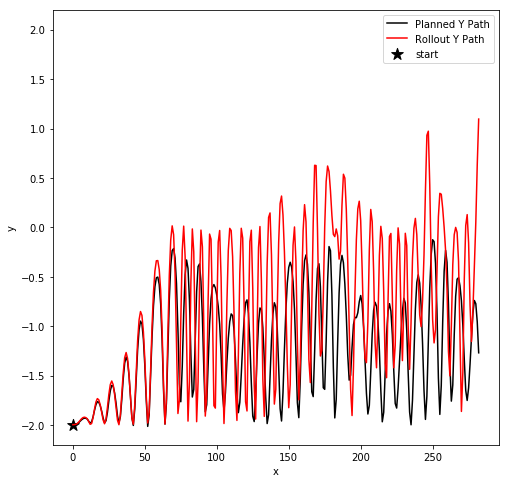

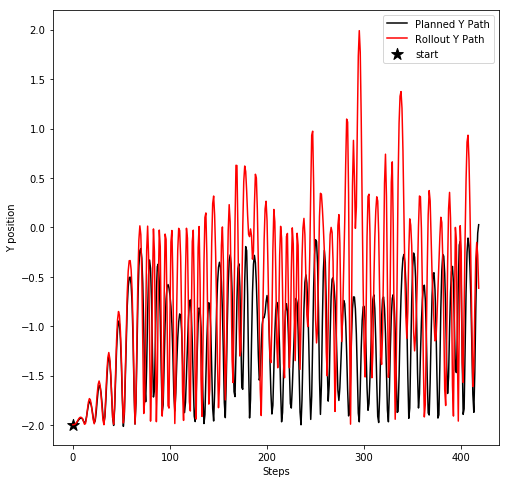

In [8]:
def rollout_acro(seed,mode,num_steps,set_path,initial_state,run_idx,plan_path,plan_action_path,goal_height):
    env.seed(seed)
    obs=env.reset()
    ro_path=obs.reshape(1,-1)
    for i in range(plan_action_path.shape[0]):
        obs=env.step(int(plan_action_path[i]))[0]
        ro_path=np.concatenate((ro_path,obs.reshape(1,-1)),axis=0)
        
    print(np.argwhere((-ro_path[:,0]-(ro_path[:,0]*ro_path[:,2]-ro_path[:,1]*ro_path[:,3]))>1))
    
    fig, ax = plt.subplots(figsize=(8,8))
    #plt.text(goal_loc[0], goal_loc[1], str(run_idx+1), fontsize=20)
    #plt.text(goal_loc[0]-3.5, goal_loc[1]-2.5, str(run_idx+1), fontsize=20)
    plt.scatter(0, -initial_state[0]-(initial_state[0]*initial_state[2]-initial_state[1]*initial_state[3]), s=150, marker='*', color ='k',label='start')
    if (-ro_path[:,0]-(ro_path[:,0]*ro_path[:,2]-ro_path[:,1]*ro_path[:,3])>=1.0).any():
        idxx=np.argwhere(-ro_path[:,0]-(ro_path[:,0]*ro_path[:,2]-ro_path[:,1]*ro_path[:,3])>=1.0)[0,0]
        plt.plot((-plan_path[:,0]-(plan_path[:,0]*plan_path[:,2]-plan_path[:,1]*plan_path[:,3]))[:idxx+1],'-k',label='Planned Y Path')
        plt.plot((-ro_path[:,0]-(ro_path[:,0]*ro_path[:,2]-ro_path[:,1]*ro_path[:,3]))[:idxx+1],'-r',label='Rollout Y Path')
        plt.ylim([-2.2, 2.2])
        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.savefig(set_path+'Acrobot-v1_'+mode+'_m'+str(num_steps)+'_run'+str(run_idx)+'_goalheightplanned_'+str(goal_height)+'_success_rollout.png',dpi=200)
        plt.show()
        fig, ax = plt.subplots(figsize=(8,8))
        #plt.text(goal_loc[0], goal_loc[1], str(run_idx+1), fontsize=20)
        #plt.text(goal_loc[0]-3.5, goal_loc[1]-2.5, str(run_idx+1), fontsize=20)
        plt.scatter(0, -initial_state[0]-(initial_state[0]*initial_state[2]-initial_state[1]*initial_state[3]), s=150, marker='*', color ='k',label='start')
        final_plan_path=plan_path[:idxx+1]
        final_ro_path=ro_path[:idxx+1]
        plt.plot(-plan_path[:,0]-(plan_path[:,0]*plan_path[:,2]-plan_path[:,1]*plan_path[:,3]),'-k',label='Planned Y Path')
        plt.plot(-ro_path[:,0]-(ro_path[:,0]*ro_path[:,2]-ro_path[:,1]*ro_path[:,3]),'-r',label='Rollout Y Path')
    else:
        plt.plot(-plan_path[:,0]-(plan_path[:,0]*plan_path[:,2]-plan_path[:,1]*plan_path[:,3]),'-k',label='Planned Y Path')
        plt.plot(-ro_path[:,0]-(ro_path[:,0]*ro_path[:,2]-ro_path[:,1]*ro_path[:,3]),'-r',label='Rollout Y Path')
        final_plan_path=plan_path
        final_ro_path=ro_path
    plt.ylim([-2.2, 2.2])
    plt.xlabel('Steps')
    plt.ylabel('Y position')
    plt.legend()
    plt.savefig(set_path+'Acrobot-v1_'+mode+'_m'+str(num_steps)+'_run'+str(run_idx)+'_goalheightplanned_'+str(goal_height)+'_rollout.png',dpi=200)
    plt.show()
    return final_plan_path,final_ro_path
    
modes=['shortest_path','quickest_search']
modes=['shortest_path']
modes=['quickest_search']
goal_height=1.0
goal_height=0
for run_idx in [1]:
    for mode in modes:
        sd=10000000+run_idx
        env.seed(sd)
        num_steps=10
        obs=env.reset()
        initial_state=obs
        print("init:",-initial_state[0]-(initial_state[0]*initial_state[2]-initial_state[1]*initial_state[3]))
        if env_name=='Acrobot-v1':
            status, plan_path, plan_action_path,len_action_path, num_expanded_nodes, max_size_fringe, total_time\
            =Astar_discrete_mstep_acro(mode,num_steps,initial_state,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,goal_height)
        print('len_of_action: ',len_action_path)
        print('num_expanded_nodes: ', num_expanded_nodes)
        res_folder='./mjo_astar_eval_results/'
        if not os.path.exists(res_folder):
            os.makedirs(res_folder)
        np.savetxt(res_folder+env_name+'_'+mode+'_m'+str(num_steps)+'_run'+str(run_idx)+'_goalheightplanned_'+str(goal_height)+'_traj.txt',plan_path, fmt='%.20f', delimiter=',')
        np.savetxt(res_folder+env_name+'_'+mode+'_m'+str(num_steps)+'_run'+str(run_idx)+'_goalheightplanned_'+str(goal_height)+'_plan.txt',plan_action_path, fmt='%.20f', delimiter=',')
        #mplot_planned_traj_acro(mode,num_steps,res_folder,initial_state,run_idx,plan_path)
        plan_path,ro_path=rollout_acro(sd,mode,num_steps,res_folder,initial_state,run_idx,plan_path,plan_action_path,goal_height)

Goal: [-0.10179293 -0.05930221]
init: [0.20983665 0.00371399]
0.32335936022357437
len_of_action:  22
num_expanded_nodes:  1048


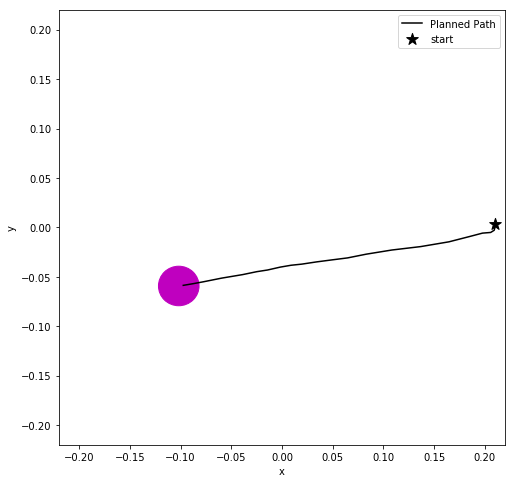

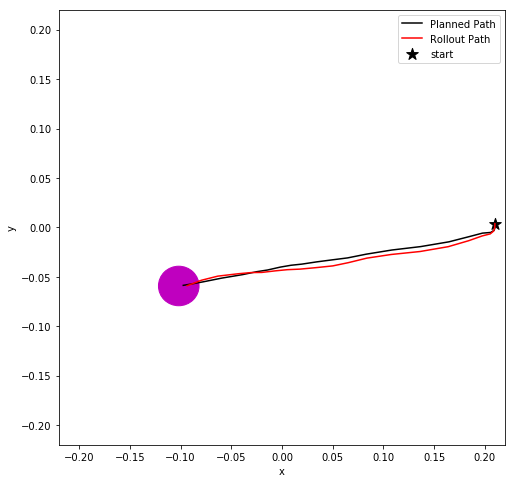

In [4]:
def rollout_reacher(seed,mode,num_steps,set_path,initial_state,run_idx,plan_path,goal_loc,big_goal_radius,plan_action_path):
    env.seed(seed)
    obs=env.reset()
    ro_path=np.concatenate((obs[:4],obs[6:8],obs[8:10]+obs[4:6])).reshape(1,-1)
    for i in range(plan_action_path.shape[0]):
        obs=env.step(plan_action_path[i])[0]
        ro_path=np.concatenate((ro_path,np.concatenate((obs[:4],obs[6:8],obs[8:10]+obs[4:6])).reshape(1,-1)),axis=0)
    fig, ax = plt.subplots(figsize=(8,8))
    goal_plan = plt.Circle((goal_loc[0], goal_loc[1]), big_goal_radius, color='m')
    ax.add_artist(goal_plan)
    #plt.text(goal_loc[0], goal_loc[1], str(run_idx+1), fontsize=20)
    #plt.text(goal_loc[0]-3.5, goal_loc[1]-2.5, str(run_idx+1), fontsize=20)
    plt.scatter(initial_state[-2], initial_state[-1], s=150, marker='*', color ='k',label='start')
    plt.plot(plan_path[:,-2],plan_path[:,-1],'-k',label='Planned Path')
    plt.plot(ro_path[:,-2],ro_path[:,-1],'-r',label='Rollout Path')
    plt.xlim([-0.22, 0.22])
    plt.ylim([-0.22, 0.22])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.savefig(set_path+'Reacher-v2_'+mode+'_m'+str(num_steps)+'_run'+str(run_idx)+'_rollout.png',dpi=200)
    plt.show()

    
env_name='Reacher-v2'
#env_name='Acrobot-v1'
model_name_suffix=''
#model_name_suffix='_all_success'
env=gym.make(env_name)
model_save_path='./trans_model_data'+model_name_suffix+'/'+env_name+'_model_lr0.0001_nodes512_seed0_epochs_50'
norm_path='./trans_model_data/'+env_name+'_normalization/normalization_arr'
with open(model_save_path, 'rb') as pickle_file:
    model = torch.load(pickle_file, map_location='cpu')
with open(norm_path, 'rb') as pickle_file:
    x_norm_arr, y_norm_arr = pickle.load(pickle_file)
    x_mean_arr, x_std_arr = x_norm_arr[0], x_norm_arr[1]
    y_mean_arr, y_std_arr = y_norm_arr[0], y_norm_arr[1]
    
modes=['shortest_path','quickest_search']
modes=['shortest_path']
#for run_idx in [1,2,5]:
for run_idx in [5]:
    for mode in modes:
        sd=1000000+run_idx
        env.seed(sd)
        big_goal_radius=0.02
        num_steps=1
        obs=env.reset()
        goal_loc=obs[4:6]
        initial_state=np.concatenate((obs[:4],obs[6:8],obs[8:10]+obs[4:6]))
        print("Goal:",goal_loc)
        print("init:",initial_state[-2:])
        if env_name=='Reacher-v2':
            status, plan_path, plan_action_path,len_action_path, num_expanded_nodes, max_size_fringe, total_time\
            =Astar_discrete_mstep_reacher(mode,num_steps,initial_state,goal_loc,model,x_std_arr,x_mean_arr,y_std_arr,y_mean_arr,big_goal_radius)
        print('len_of_action: ',len_action_path)
        print('num_expanded_nodes: ', num_expanded_nodes)
        res_folder='./mjo_astar_eval_results/'
        if not os.path.exists(res_folder):
            os.makedirs(res_folder)
        np.savetxt(res_folder+env_name+'_'+mode+'_m'+str(num_steps)+'_run'+str(run_idx)+'_traj.txt',plan_path, fmt='%.20f', delimiter=',')
        np.savetxt(res_folder+env_name+'_'+mode+'_m'+str(num_steps)+'_run'+str(run_idx)+'_plan.txt',plan_action_path, fmt='%.20f', delimiter=',')
        mplot_planned_traj_reacher(mode,num_steps,res_folder,initial_state,run_idx,plan_path,goal_loc,big_goal_radius)
        rollout_reacher(sd,mode,num_steps,res_folder,initial_state,run_idx,plan_path,goal_loc,big_goal_radius,plan_action_path)

In [8]:
plan_action_path

array([[-1,  1],
       [ 0,  1],
       [-1,  1],
       [ 0,  1],
       [-1,  0],
       [ 0,  1],
       [-1,  0],
       [ 1, -1],
       [-1, -1],
       [ 1, -1],
       [-1,  0],
       [-1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 0, -1],
       [ 1,  0],
       [ 1,  0],
       [ 0, -1],
       [ 1, -1],
       [ 1,  1],
       [-1,  1],
       [ 1, -1]])

In [11]:
np.linalg.norm(plan_path[0,-2:]-plan_path[-1,-2:])

0.31345420125568424

In [32]:
not np.array([True])

False

In [36]:
(None,) + (3,)

(None, 3)

In [2]:
import numpy as np
np.random.randint(2)

1

In [1]:
import numpy as np

In [2]:
np.arange(0,10,3)

array([0, 3, 6, 9])

In [5]:
a=np.zeros(2)
np.array([a])

array([[0., 0.]])